In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [2]:
train_db = pd.read_csv("train.csv")
test_db = pd.read_csv("test.csv")

In [3]:
train_db.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_db.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train_db.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test_db.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
X_train = train_db.Name
Y_train = train_db.Survived
X_test = test_db.Name

In [8]:
X_train.describe()
Y_train.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [9]:
X_test.describe()

count                                                   418
unique                                                  418
top       Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genev...
freq                                                      1
Name: Name, dtype: object

In [10]:
X_train.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [11]:
max_length = 0
for names in X_train:
    if len(names) > max_length:
        max_length = len(names)
        
print(max_length)

82


In [12]:
text = ""
for names in X_train:
    text += " " + names

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [14]:
text_to_word = text_to_word_sequence(
    text,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=False, split=' '
)

In [15]:
len(text_to_word)

3638

In [16]:
unique_words = []
for word in text_to_word:
    if word not in unique_words:
        unique_words.append(word)

In [17]:
tokenizer = Tokenizer(num_words=len(unique_words) , oov_token="<oov>")
tokenizer.fit_on_texts(X_train)

In [18]:
def prep_text(texts, tokenizer, max_sequence_length):
    # Turns text into into padded sequences.
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, maxlen=max_length)

In [19]:
train_X = prep_text(X_train, tokenizer, 100)
test_X = prep_text(X_test, tokenizer, 100)


In [20]:
print("Train shape: ", train_X.shape)
print("Test shape: ", test_X.shape)

Train shape:  (891, 82)
Test shape:  (418, 82)


In [21]:
train_Y = Y_train.to_numpy().reshape(-1, 1)

In [22]:
print("Train Y shape: ", train_Y.shape)

Train Y shape:  (891, 1)


In [153]:
split = 89
t_X = train_X[:len(train_X) - split,:]
t_Y = train_Y[:len(train_X) - split,:]
val_X = train_X[len(train_X) - split: len(train_X),:]
val_Y = train_Y[len(train_X) - split: len(train_X),:]

In [154]:
t_X.shape

(802, 82)

In [155]:
val_X.shape

(89, 82)

In [156]:
def creat_model():
    
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=len(unique_words), output_dim=64))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.Dropout(0.75))
    model.add(layers.LSTM(32))
    model.add(layers.Dropout(0.75))
    model.add(layers.Dense(16))
    model.add(layers.Dropout(0.90))
    model.add(layers.Dense(1,  activation="sigmoid"))
    
    model.summary()
    
    return model

In [157]:
model = creat_model()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, None, 64)          97856     
_________________________________________________________________
lstm_32 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
dropout_74 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_75 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_76 (Dropout)         (None, 16)              

In [158]:
model.compile(loss =tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=["acc"])

In [159]:
history = model.fit(t_X, t_Y, epochs=4, verbose=1, validation_data=(val_X, val_Y))

Epoch 1/4
26/26 [==============================] - 155s 943ms/step - loss: 0.7079 - acc: 0.5592 - val_loss: 0.6666 - val_acc: 0.6292
Epoch 2/4
26/26 [==============================] - 19s 713ms/step - loss: 0.6729 - acc: 0.5960 - val_loss: 0.6569 - val_acc: 0.6292
Epoch 3/4
26/26 [==============================] - 17s 644ms/step - loss: 0.6510 - acc: 0.6037 - val_loss: 0.5641 - val_acc: 0.7303
Epoch 4/4
26/26 [==============================] - 12s 472ms/step - loss: 0.5838 - acc: 0.6840 - val_loss: 0.5921 - val_acc: 0.7528


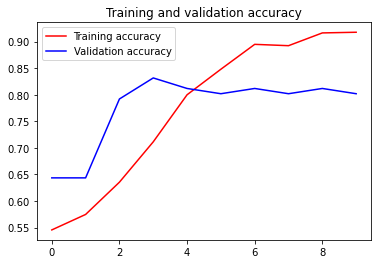

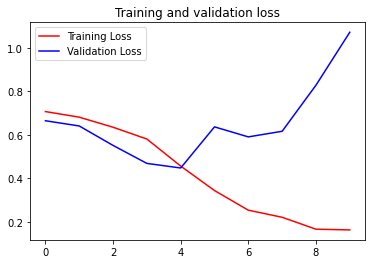

In [149]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [108]:
predict = model.predict(
    test_X,
    batch_size=None,
    verbose=1,
)

14/14 [==============================] - 2s 25ms/step


In [32]:
sample = np.zeros(predict.shape)
sample[predict > 0.65] = 1 

In [109]:
sample_pd = pd.DataFrame(sample)

In [110]:
sample_pd

,0
0,0.0
1,1.0
2,0.0
3,0.0
4,1.0
...,...
413,0.0
414,1.0
415,0.0
416,0.0


In [111]:
test_db.PassengerId

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [112]:
sample_final = pd.concat([test_db.PassengerId, sample_pd.astype(int)], axis =1)

In [113]:
sample_final.columns=[['PassengerId', 'Survived']]

In [114]:
sample_final.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [115]:
sample_final.to_csv("submission2.csv", index=False)